# Attempt at blending

In [1]:
import emcee
import pylab as p
import numpy as np
from numpy import *
import pandas as pd
from tqdm import tqdm 
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import roc_auc_score as skl_roc_auc_score

In [2]:
### Read in the original data

# Read in the TOXIC competition data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Target labels
ycols = train.columns[2:]
ys = train[ycols].values

print('Reading the challenge data...')
print( '%-27s %-10i' % ('Size of the training set:', len(train)))
print( '%-27s %-10i' % ('Size of the testing set:', len(test)))
print()

Reading the challenge data...
Size of the training set:   159571    
Size of the testing set:    153164    



### Read in the master data file

In [3]:
master_list = pd.read_csv('../xmodel_list.txt', delim_whitespace=True, names=['id', 'logloss', 'roc'])

### Read in all available NN predictions

In [4]:
# Reading the data in
# dfs = zeros(len(master_list), dtype='O') # the training x-validation sets
# dds = zeros(len(master_list), dtype='O') # the testing prediction sets
dfs = zeros((len(master_list), train.shape[0], 6))
dds = zeros((len(master_list), test.shape[0], 6))
for i,v in enumerate(tqdm(master_list['id'].values)):
    dfs[i] = pd.read_csv('../xvalidations/'+v[:-1]+'.csv.bz', compression='bz2')[ycols].values
    dds[i] = pd.read_csv('../xsubmissions/'+v[:-1]+'.csv')[ycols].values

# The scaling (overwritting the original stuff, in memory of course)
for i,v in enumerate(dfs):
    dfs[i] = minmax_scale(v)

for i,v in enumerate(dds):
    dds[i] = minmax_scale(v)

100%|██████████| 34/34 [00:51<00:00,  1.51s/it]


### Choose the best models
 - this was done in the bagging notebook

In [5]:
best_models = array([ 0,  1,  5,  7,  9, 11, 13, 16, 25, 26, 27, 31, 32])

# Choose only the relevant models
dfs = dfs[best_models]
dds = dds[best_models]

print('Best local roc:', skl_roc_auc_score(ys, dfs.mean(axis=0) ))

Best local roc: 0.99216051026


Best local roc: 0.99216051026

### Some attempt at blending, or at least at custom averaging

In [6]:
# The "likelihood" sort of..
def myfunc(params, X, y):
    yhat = np.average(X, weights=params, axis=0)
    return skl_roc_auc_score(y, yhat)

# The priors, more like defining the boundaries of the parameters (weights)
def prior(params):
    if (params < 1).all() and (params >= 0).all():
        return 0.0
    else:
        return -np.inf

# The full function thingy, likelihood + priors
def ffunc(params, X, y):
    lp = prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + myfunc(params, X, y)

In [7]:
weights = ones(len(dfs))*1/len(dfs)

In [8]:
ndim, nwalkers = 13, 500
pos = [weights + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ffunc, args=(dfs, ys), threads=1)

In [10]:
%%time 
tmp = sampler.run_mcmc(pos, 5)

CPU times: user 11min 36s, sys: 1min 39s, total: 13min 15s
Wall time: 13min 16s


In [151]:
### This does not include the burn in period
res = sampler.chain[:, :, :].reshape((-1, ndim))

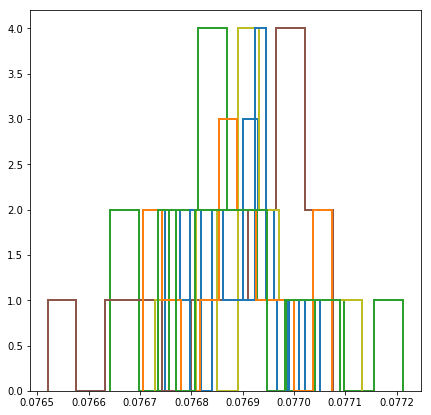

In [162]:
p.figure(figsize=(7,7))
for i in range(13):
    p.hist(res[i], histtype='step', lw=2)
p.show()

### Final weight and roc:

In [176]:
final_weights = res.mean(axis=0)

print('calibrated local roc:', skl_roc_auc_score(ys, np.average(dfs, axis=0, weights=final_weights)))

calibrated local roc: 0.992160490483


Best local roc from the Bagging phase: 0.99216051026

### If you like what you see: ready for submission

In [181]:
# The sample submission file
ss = pd.read_csv('../sample_submission.csv')
# Update the results in that file
ss[ycols] = np.average(dds, axis=0, weights=final_weights)
# Save the DataFrame to a new file on disk:
ss.to_csv('./submission_blend_nn_goodmodels.csv', index=False)



# Also save results to disk for the next level
# The validations (training set)
dfs_out = pd.DataFrame(np.average(dfs, axis=0, weights=final_weights), columns=ycols)
dfs_out.to_csv(path_or_buf='./train_blend_NN.csv.bz2', index=False, compression='bz2')
# The submission (testing set)
dds_out = pd.DataFrame(np.average(dds, axis=0, weights=final_weights), columns=ycols)
dds_out.to_csv(path_or_buf='./test_blend_NN.csv.bz2', index=False, compression='bz2')
